### RUN NEXT 3 CELLS TO RUN IMAGE GRID

In [4]:
from keras import Sequential, layers,optimizers
from keras.datasets import cifar10
from keras.layers import Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose,Input
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop
from keras import initializers
import keras as k
from keras.backend import mean
from keras import Model
import numpy as np
from keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from skimage import transform
from keras.layers.core import Lambda
from keras.layers import Input,UpSampling2D,Activation
from keras.initializers import TruncatedNormal
from keras.engine.network import Layer
from skimage import transform
from scipy.linalg import sqrtm
from keras.models import model_from_json
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import TensorBoard
from keras.models import load_model

Using TensorFlow backend.


### Self Attention Layer

In [0]:
'''CUSTOM LAYER FOR SELF ATTENTION'''

from keras.engine.network import Layer
from keras.layers import InputSpec
import keras.backend as K

class SelfAttention(Layer):
  
  #config file to load the model
    def get_config(self):
        config = {'ch' : self.channels}
        base_config = super(SelfAttention,self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
      
    def __init__(self, ch, **kwargs):
        print('init')
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        print('build')
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f',
                                        trainable=True)
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g',
                                        trainable=True)
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h',
                                        trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True

    def call(self, x):
        print('call')
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[3]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]

        s = K.batch_dot(hw_flatten(g), K.permute_dimensions(hw_flatten(f), (0, 2, 1)))  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape



### Spectral Normalisation Layer

In [0]:
'''CUSTOMER LAYER FOR SPECTRAL NORMALISATION'''
#IMPORTED FROM https://github.com/kiyohiro8/SelfAttentionGAN/blob/master/SpectralNormLayer.py

from keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
        
class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)
    
    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        #Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(0, 1),
                                     name='sn',
                                     trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        
        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            #Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            #Calculate Sigma
            sigma=K.dot(_v, W_reshaped)
            sigma=K.dot(sigma, K.transpose(_u))
            #normalize it
            W_bar = W_reshaped / sigma
            #reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            #update weitht
            self.kernel = W_bar
        
        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
class ConvSN1D(Conv1D):
    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                 initializer=initializers.RandomNormal(0, 1),
                 name='sn',
                 trainable=False)
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv1d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class ConvSN3D(Conv3D):    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv3d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

        
class EmbeddingSN(Embedding):
    
    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.input_dim, self.output_dim),
            initializer=self.embeddings_initializer,
            name='embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            dtype=self.dtype)
        
        self.u = self.add_weight(shape=tuple([1, self.embeddings.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        self.built = True
        
    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
            
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.embeddings.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.embeddings, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.embeddings = W_bar
            
        out = K.gather(self.embeddings, inputs)
        return out 

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)
            
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


### Define Generator

In [0]:
'''BUILD GENERATOR  '''
'''Exactly like DCGAN with these changes'''
'''Consists of 4 Convolution2D Transpose layers with Spectral Normalisation starting from dimension 256 till 3
    One self attention layer at dimension 128. 
and 1 Dense layer'''

def get_generator(latent_dim):
    n_nodes = 512 * 2 * 2
    in_x = Input(shape=(latent_dim,))
    x = Dense(n_nodes, input_shape=(latent_dim,))(in_x)
    x = Reshape((2, 2, 512))(x)
    #1
    x = ConvSN2DTranspose(256,kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #2
    x = ConvSN2DTranspose(128,kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #Self Attention
    x = SelfAttention(128)(x)
    
    #3
    x = ConvSN2DTranspose(64,kernel_size=3, strides= 2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    
    # output layer
    x = ConvSN2DTranspose(3, (3,3), strides= 2, activation='tanh', padding='same')(x)
    model = Model(in_x,x)
    return model

In [0]:
## RUN THIS CELL TO CALCULATE FID FOR 10K IMAGES AND DISPLAY 8 x 8 GRID

init
build
call


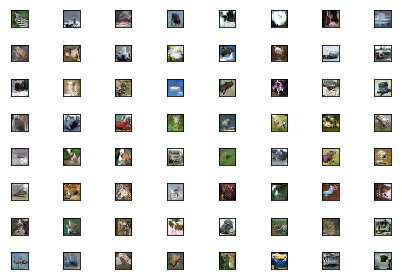

170500096/170498071 [==============================] - 5s 0us/step


87916544/87910968 [==============================] - 1s 0us/step
****fid ****43.83644821396465


In [9]:
def load_model(JsonfileName,weightFileName):
  mJson = open(JsonfileName,'r')
  model_json = mJson.read()
  mJson.close()
  model = model_from_json(model_json,custom_objects={'SelfAttention' : SelfAttention,
                                          'EmbeddingSN' : EmbeddingSN,
                                          'ConvSN2D' : ConvSN2D,
                                          'DenseSN' : DenseSN,
                                          'ConvSN2DTranspose' : ConvSN2DTranspose})
  model.load_weights(weightFileName)
  return model

def calculate_fid(act1, act2):
    # calculate activations
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
  
def resizeForInceptionV3(images1):
  imgList = list()
  for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)  

'''LOAD MODEL'''
generator = load_model('generatorSA(NonC) (1).json','generatorSA(NonC) (1).h5')
samples = 64
latent_dim = 100
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

for k in range(samples):
    plt.subplot(8, 8, k + 1, xticks=[], yticks=[])
    plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

plt.tight_layout()
plt.show()

'''Calculate FID for 10k images'''
print('Calculating FID please wait..')
resizedReal = []
resizedFake = []
samples = 10000
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
for size in range(len(xTest)//250):
  images1 = resizeForInceptionV3(x_fake[size*250:(size+1)*250])
  images2 = resizeForInceptionV3(xTest[size*250:(size+1)*250])
  act1 = inceptionModel.predict(images1)
  act2 = inceptionModel.predict(images2)
  for act in act1:
    resizedReal.append(act)
  for act in act2:
    resizedFake.append(act)
fid = calculate_fid(np.asarray(resizedReal),np.asarray(resizedFake))
print('****fid ****'+str(fid))

### Calculate FID

In [0]:
def calculate_fid(act1, act2):
  
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Define Discriminator

In [0]:
'''BUILD DISCRIMINATOR  '''
'''Exactly like DCGAN with these changes'''
'''Consists of 4 Convolution2D layers with Spectral Normalisation starting from dimension 64 till 512
    One self attention layer at dimension 128
and 1 Dense layer'''

def get_discriminator(inp_dim):
    #1
    in_x = Input(shape=inp_dim)
    x = ConvSN2D(64,kernel_size=5,strides=2,input_shape =  inp_dim)(in_x)
    x = LeakyReLU(0.2)(x)
    #2
    x = ConvSN2D(128,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #3
    x = SelfAttention(128)(x)
    x = ConvSN2D(256,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #4
    x = ConvSN2D(512,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = DenseSN(1, activation=None)(x)
    model = Model(in_x,x)
    return model

### Resize Image for inception model

In [0]:
def resizeForInceptionV3(images1):
  #Declare empty list to store images
  imgList = list()
  
  #Resize each incoming image and add to list
    for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)

### Function to save model

In [0]:
#Save model architecture as Json and weights as h5 file

def save_model(model,JsonfileName,weightFileName):
  model_json = model.to_json()
  with open('/content/drive/DLProject1'+JsonfileName,'w') as json_file:
    json_file.write(model_json)
  model.save_weights('/content/drive/DLProject1'+weightFileName)


### Function to load model

In [0]:
def load_mymodel(model,JsonfileName,weightFileName):
  mJson = open(JsonfileName,'r')
  model_json = mJson.read()
  mJson.close()
  model = model_from_json(model_json,custom_objects={'SelfAttention': SelfAttention,'DenseSN' : DenseSN,
                                                     'ConvSN2D':ConvSN2D,'ConvSN2DTranspose':ConvSN2DTranspose})
  model.load_weights(weightFileName)
  return model

### Import Dataset and build discriminator and generator

In [0]:
#Download CIFAR10 Dataset
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

#Specify input dimensions
inp_dim = xTrain[0].shape

#Normalize
xTrain = (xTrain-127.5)/127.5

#Build discriminator
discriminator = get_discriminator(inp_dim)

#Compile discriminator
discriminator.compile(RMSprop(lr=0.0004), loss='hinge',
                      metrics=['binary_accuracy'])

#Build generator
generator = get_generator(100)

170500096/170498071 [==============================] - 6s 0us/step




init
build
<class '__main__.SelfAttention'>
call









init
build
<class '__main__.SelfAttention'>
call


### Function for combined model

In [0]:
def define_gan(generator, discriminator,latent_dim):
    discriminator.trainable = False
    
    #Noise generation
    z = Input(shape=(latent_dim,))
    
    #Give noise input to generator to predict image
    img = generator(z)
    
    #Pass generated image to discriminator
    decision = discriminator(img)
    
    #Compile model and return
    d_g = Model(inputs=z, outputs=decision)
    d_g.compile(RMSprop(lr=0.0004), loss='hinge',
                metrics=['binary_accuracy'])
    return d_g

In [0]:
'''Build combined model '''
latent_dim = 100
gan = define_gan(generator,discriminator,latent_dim)

call
call


### Train Model

call
call


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


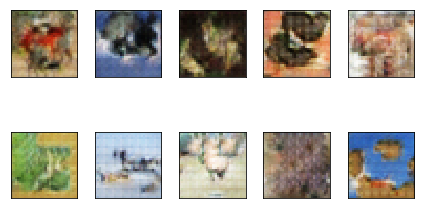

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch = 0 dLoss =0.6923083662986755 gLoss = 1.8277447


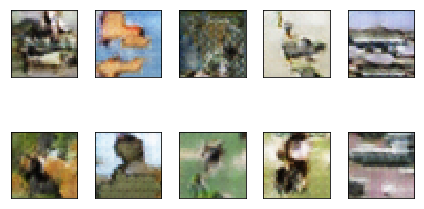

IN FID 
****fid ****49.83122738614996
 Epoch = 1 dLoss =0.6648085117340088 gLoss = 1.9296091


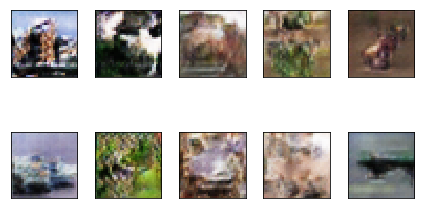

IN FID 
****fid ****50.49073489996316
 Epoch = 2 dLoss =0.649523138999939 gLoss = 1.9598411


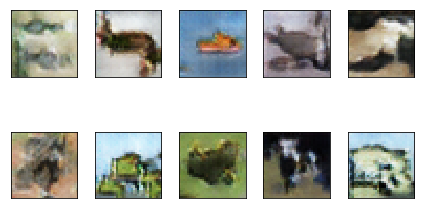

IN FID 
****fid ****45.91429407431782
 Epoch = 3 dLoss =0.7022534608840942 gLoss = 1.8914193


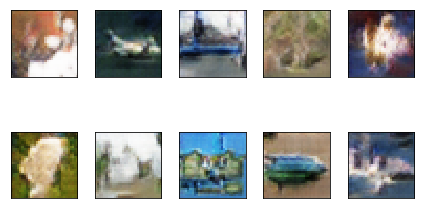

 Epoch = 4 dLoss =0.5940840244293213 gLoss = 1.8908538


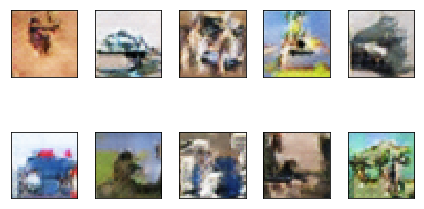

IN FID 
****fid ****50.467229554870514
 Epoch = 5 dLoss =0.6251222491264343 gLoss = 1.9641201


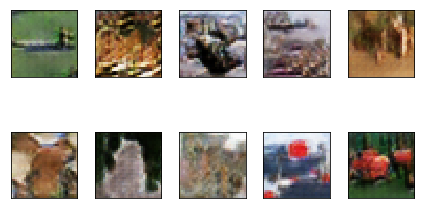

IN FID 
****fid ****47.75155810961702
 Epoch = 6 dLoss =0.5514686107635498 gLoss = 2.0296078


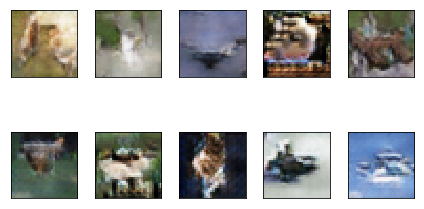

IN FID 
****fid ****45.972383084776006
 Epoch = 7 dLoss =0.5833064913749695 gLoss = 1.9785421


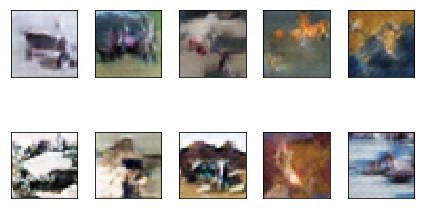

IN FID 
****fid ****46.017222312823485
 Epoch = 8 dLoss =0.563639760017395 gLoss = 1.9895


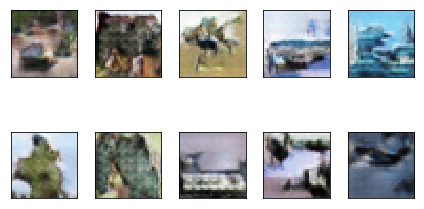

 Epoch = 9 dLoss =0.6509280800819397 gLoss = 1.9313464


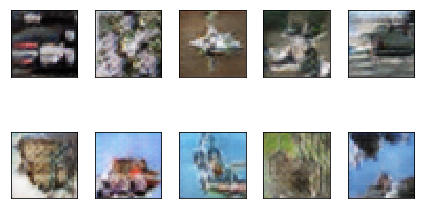

IN FID 
****fid ****45.95151720520783
 Epoch = 10 dLoss =0.6662091016769409 gLoss = 1.9485971


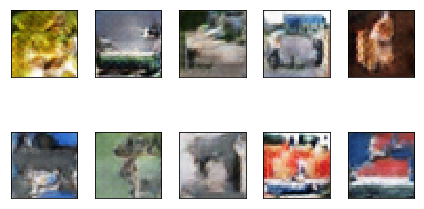

IN FID 
****fid ****45.574599436061376
 Epoch = 11 dLoss =0.601211667060852 gLoss = 2.0646436


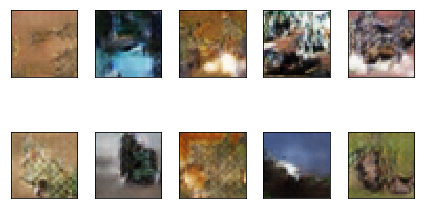

IN FID 
****fid ****47.76206352723613
 Epoch = 12 dLoss =0.578366756439209 gLoss = 1.9542606


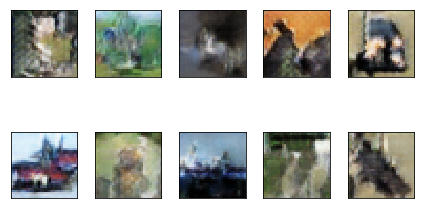

 Epoch = 13 dLoss =0.5823943614959717 gLoss = 1.9177179


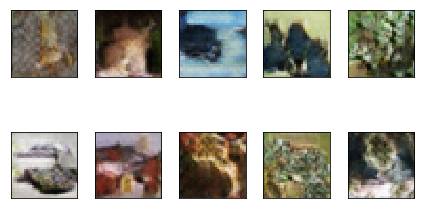

IN FID 
****fid ****47.01851248113472
 Epoch = 14 dLoss =0.5979726314544678 gLoss = 1.9853741


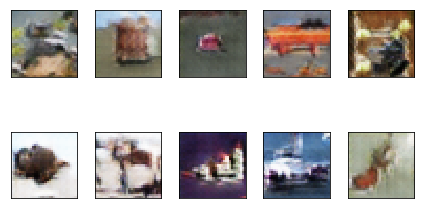

IN FID 
****fid ****44.78361512249434
 Epoch = 15 dLoss =0.5222876071929932 gLoss = 2.0887918


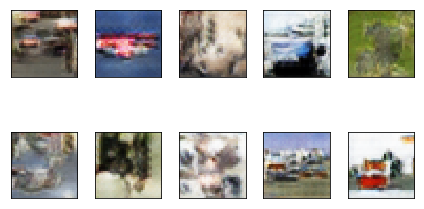

IN FID 
****fid ****44.415213624810406
 Epoch = 16 dLoss =0.4939917325973511 gLoss = 2.0797286


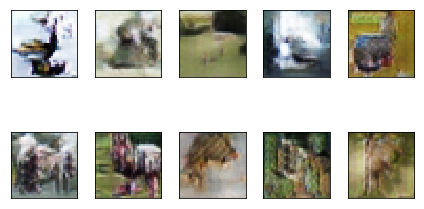

IN FID 
****fid ****44.21051639457669
 Epoch = 17 dLoss =0.5898922085762024 gLoss = 1.8336251


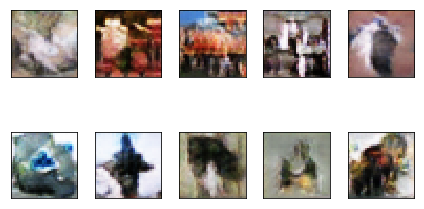

 Epoch = 18 dLoss =0.4740484952926636 gLoss = 2.0173657


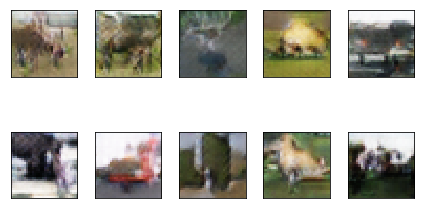

IN FID 
****fid ****44.850587383913066
 Epoch = 19 dLoss =0.5816007852554321 gLoss = 1.923699


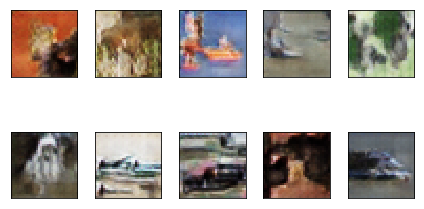

IN FID 
****fid ****44.580831577479294
 Epoch = 20 dLoss =0.5015989542007446 gLoss = 2.1159096


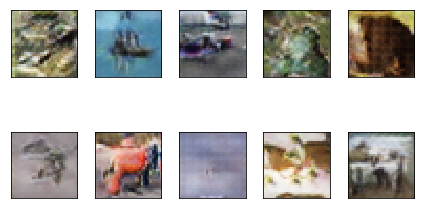

IN FID 
****fid ****43.64704337991161
 Epoch = 21 dLoss =0.5510040521621704 gLoss = 2.0680346


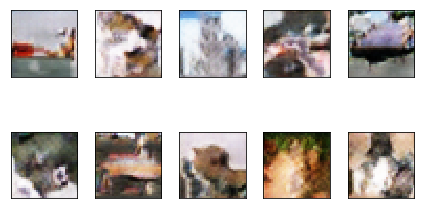

 Epoch = 22 dLoss =0.5470740795135498 gLoss = 2.026091


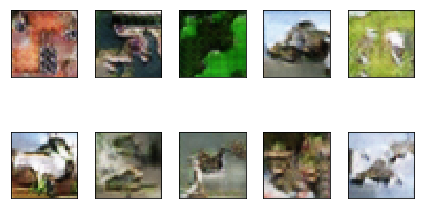

IN FID 
****fid ****42.24085743726583
 Epoch = 23 dLoss =0.46575984358787537 gLoss = 2.1004167


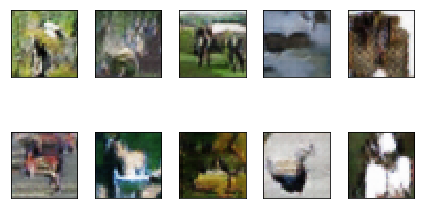

IN FID 
****fid ****43.81755740070368
 Epoch = 24 dLoss =0.47959616780281067 gLoss = 2.158146


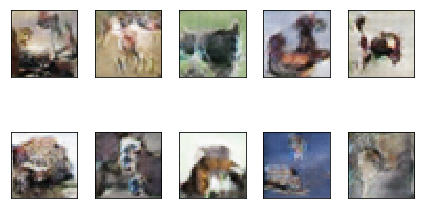

IN FID 


In [0]:
#Train from scratch

#Declare batch size
batch_size = 64
smooth = 0.1

#Declare real/true labels[ALL 1]
real = np.ones(shape=(batch_size, 1))

#Declare real/true labels[ALL -1]
fake = np.ones((batch_size, 1))
fake = -fake
epoch = 100
fidL = []
dLoss = []
gLoss = []
fidCounter = 0

# Declare inceptionModel for calculating FID
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

gan  = define_gan(generator,discriminator,latent_dim=latent_dim)
for i in range(0,epoch):
  for j in range(len(xTrain) // batch_size):
    discriminator.trainable = False
    
    # Train on Real
    X_batch = xTrain[j*batch_size:(j+1)*batch_size]
    dLossReal = discriminator.train_on_batch(X_batch,real)
    
    #Train on Fake
    z = np.random.normal(loc = 0,scale = 1,size = (batch_size,latent_dim))
    X_fake = generator.predict_on_batch(z)
    dLossFake = discriminator.train_on_batch(x=X_fake,y=fake)
    
    #Discriminator Loss 
    d_loss =  0.5 * (dLossReal[0] + dLossFake[0])
    discriminator.trainable = False
    g_loss = gan.train_on_batch(x=z, y=real)
    
    '''FOR 10k FID'''
    fidCounter=fidCounter+1;
    if fidCounter == 1000:
      fidCounter = 1
      print('IN FID ')
      resizedReal = []
      resizedFake = []
      samples = 10000
      x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
      for size in range(len(xTest)//250):
        images1 = resizeForInceptionV3(x_fake[size*250:(size+1)*250])
        #resizedFake.append(images1)
        images2 = resizeForInceptionV3(xTest[size*250:(size+1)*250])
        act1 = inceptionModel.predict(images1)
        act2 = inceptionModel.predict(images2)
        for act in act1:
          resizedReal.append(act)
        for act in act2:
          resizedFake.append(act)
      fid = calculate_fid(np.asarray(resizedReal),np.asarray(resizedFake))
      print('****fid ****'+str(fid))
      fidL.append(str(fid))
      tensorboard.on_epoch_end(epoch,{"fid":fid}) 
      
    #PLOT images to check progress
    if j % 1000 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
          
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()
        tensorboard.on_epoch_end(j, {"D_real_loss":dLossReal[0] ,"D_fake_loss":dLossFake[0],"GAN_loss":g_loss[0]})
        
  #tensorboard.on_epoch_end(epoch, {"D_real_loss":dLossReal[0] ,"D_fake_loss":dLossFake[0],"GAN_loss":g_loss[0],"fid":fid}) 
  dLoss.append(str(d_loss))
  gLoss.append(str(g_loss[0]))
  print(' Epoch = '+str(i)+ ' dLoss ='+str(d_loss)+' gLoss = '+str(g_loss[0]))
  
  #Save model
  save_model(generator,'generatorSA(NonC).json','generatorSA(NonC).h5')
  save_model(discriminator,'discriminatorSA(NonC).json','discriminatorSA(NonC).h5')
  save_model(gan,'ganSA(NonC).json','ganSA(NonC).h5')
  



In [0]:
#Declare tensorboard object

tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/DLProject1/SALogsNonC',
  histogram_freq=0,
  batch_size=64,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(gan)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
